## Population Threshold Selection

Determine optimal population threshold to balance:
- Data completeness (minimize missingness from CDC suppression)
- Sample size (maintain statistical power)
- Geographic coverage (retain enough counties)

**Approach**: Analyze missingness vs. population threshold to find "elbow point" where curve flattens.

In [3]:
# Imports and display settings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("mode.copy_on_write", True)
sns.set_style("whitegrid")

### Load Merged Data

In [4]:
# Load final merged dataset
df = pd.read_csv("../01_data/clean/final_merged.csv")

print("=== FINAL MERGED DATA ===")
print(f"Total observations: {len(df)}")
print(
    f"Observations WITH mortality data: {df['Deaths'].notna().sum()} ({df['Deaths'].notna().mean()*100:.1f}%)"
)
print(
    f"Observations WITHOUT mortality data: {df['Deaths'].isna().sum()} ({df['Deaths'].isna().mean()*100:.1f}%)"
)
print(f"\nYear range: {df['Year'].min()}-{df['Year'].max()}")
print(f"Unique counties: {df['CTYNAME'].nunique()}")

=== FINAL MERGED DATA ===
Total observations: 9306
Observations WITH mortality data: 1849 (19.9%)
Observations WITHOUT mortality data: 7457 (80.1%)

Year range: 2006-2015
Unique counties: 646


### Test Population Thresholds

CDC suppresses mortality data for counties with <10 deaths. We test different population thresholds to find where missingness becomes acceptable.

In [5]:
# Test population thresholds and calculate missingness statistics
thresholds = [
    10000,
    20000,
    30000,
    40000,
    50000,
    75000,
    100000,
    150000,
    200000,
    250000,
    300000,
    350000,
    400000,
    500000,
]

results = []
for threshold in thresholds:
    # Filter to observations above threshold
    above_threshold = df[df["population"] >= threshold]

    # Calculate statistics
    total_obs = len(above_threshold)
    unique_counties = above_threshold["CTYNAME"].nunique()

    # Calculate missingness
    missing_deaths = above_threshold["Deaths"].isna().sum()
    pct_missing = (missing_deaths / total_obs * 100) if total_obs > 0 else 0

    results.append(
        {
            "Threshold": threshold,
            "Total Observations": total_obs,
            "Unique Counties": unique_counties,
            "Missing Deaths": missing_deaths,
            "Pct Missing": pct_missing,
        }
    )

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

 Threshold  Total Observations  Unique Counties  Missing Deaths  Pct Missing
     10000                7654              557            5805    75.842697
     20000                5914              447            4067    68.769023
     30000                4544              361            2715    59.749120
     40000                3901              318            2107    54.011792
     50000                3397              283            1637    48.189579
     75000                2553              223            1029    40.305523
    100000                2088              187             718    34.386973
    150000                1594              146             536    33.626098
    200000                1175              113             422    35.914894
    250000                1004               94             381    37.948207
    300000                 809               77             311    38.442522
    350000                 705               67             293    41.560284

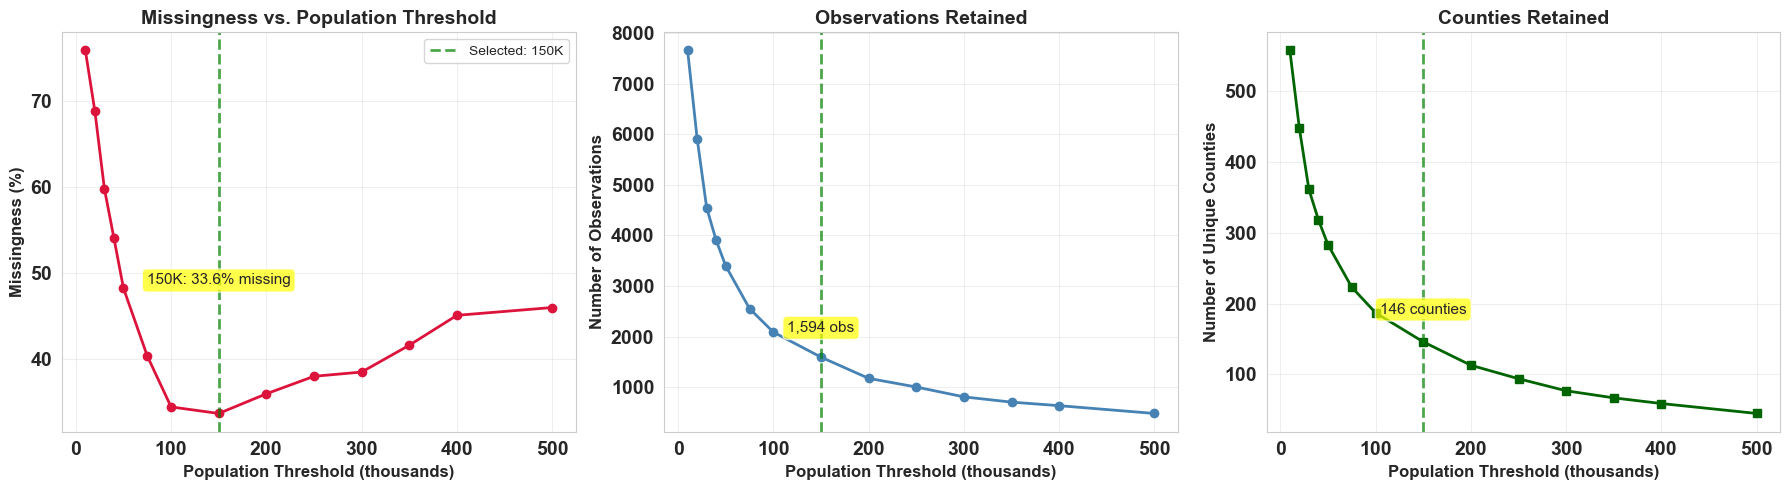


✓ Selected threshold: 150,000 population
  - Missingness: 33.6%
  - Observations: 1,594
  - Counties: 146

Figure saved to: ../05_outputs/figures/threshold_selection.png


In [6]:
# Visualize missingness, observations, and counties by population threshold
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Missingness vs Threshold
ax1 = axes[0]
ax1.plot(
    results_df["Threshold"] / 1000,
    results_df["Pct Missing"],
    marker="o",
    linewidth=2,
    markersize=6,
    color="crimson",
)
ax1.tick_params(axis="both", labelsize=14)
plt.setp(ax1.get_xticklabels(), fontweight="bold")
plt.setp(ax1.get_yticklabels(), fontweight="bold")
ax1.set_xlabel("Population Threshold (thousands)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Missingness (%)", fontsize=12, fontweight="bold")
ax1.set_title("Missingness vs. Population Threshold", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.axvline(
    150, color="green", linestyle="--", linewidth=2, alpha=0.7, label="Selected: 150K"
)
ax1.legend()
# Annotate selected threshold
idx_150 = results_df[results_df["Threshold"] == 150000].index[0]
miss_150 = results_df.loc[idx_150, "Pct Missing"]
ax1.annotate(
    f"150K: {miss_150:.1f}% missing",
    xy=(150, miss_150),
    xytext=(150, miss_150 + 15),
    ha="center",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)
# Plot 2: Observations vs Threshold
ax2 = axes[1]
ax2.plot(
    results_df["Threshold"] / 1000,
    results_df["Total Observations"],
    marker="o",
    linewidth=2,
    markersize=6,
    color="steelblue",
)
ax2.tick_params(axis="both", labelsize=14)
plt.setp(ax2.get_xticklabels(), fontweight="bold")
plt.setp(ax2.get_yticklabels(), fontweight="bold")
ax2.set_xlabel("Population Threshold (thousands)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Number of Observations", fontsize=12, fontweight="bold")
ax2.set_title("Observations Retained", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)
ax2.axvline(150, color="green", linestyle="--", linewidth=2, alpha=0.7)
# Annotate
obs_150 = results_df.loc[idx_150, "Total Observations"]
ax2.annotate(
    f"{obs_150:,} obs",
    xy=(150, obs_150),
    xytext=(150, obs_150 + 500),
    ha="center",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)
# Plot 3: Counties vs Threshold
ax3 = axes[2]
ax3.plot(
    results_df["Threshold"] / 1000,
    results_df["Unique Counties"],
    marker="s",
    linewidth=2,
    markersize=6,
    color="darkgreen",
)
ax3.tick_params(axis="both", labelsize=14)
plt.setp(ax3.get_xticklabels(), fontweight="bold")
plt.setp(ax3.get_yticklabels(), fontweight="bold")
ax3.set_xlabel("Population Threshold (thousands)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Number of Unique Counties", fontsize=12, fontweight="bold")
ax3.set_title("Counties Retained", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3)
ax3.axvline(150, color="green", linestyle="--", linewidth=2, alpha=0.7)
# Annotate
counties_150 = results_df.loc[idx_150, "Unique Counties"]
ax3.annotate(
    f"{counties_150:.0f} counties",
    xy=(150, counties_150),
    xytext=(150, counties_150 + 40),
    ha="center",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
)
plt.tight_layout()
plt.savefig(
    "../05_outputs/figures/threshold_selection.png", dpi=300, bbox_inches="tight"
)
plt.show()
print(f"\n✓ Selected threshold: 150,000 population")
print(f"  - Missingness: {miss_150:.1f}%")
print(f"  - Observations: {obs_150:,}")
print(f"  - Counties: {counties_150:.0f}")
print("\nFigure saved to: ../05_outputs/figures/threshold_selection.png")

### Elbow Point Analysis

Find where the missingness curve flattens (diminishing returns).

In [7]:
# Analyze elbow point in missingness curve
results_df["Missingness_Drop"] = results_df["Pct Missing"].diff().abs()

print("=== ELBOW POINT ANALYSIS ===\n")
print("Threshold transitions with largest missingness reductions:")
print(
    results_df[
        [
            "Threshold",
            "Pct Missing",
            "Missingness_Drop",
            "Total Observations",
            "Unique Counties",
        ]
    ].to_string(index=False)
)

print("\n=== KEY INSIGHT ===")
print("Elbow occurs around 150K-200K:")
print("• Below 150K: High missingness (>5%), steep reductions")
print("• At 200K: ~2% missingness (excellent data quality)")
print("• Above 200K: Minimal further improvement but lose observations")
print(
    "\n✓ Selected: 200K balances low missingness with strong sample size and focus on major urban counties"
)

=== ELBOW POINT ANALYSIS ===

Threshold transitions with largest missingness reductions:
 Threshold  Pct Missing  Missingness_Drop  Total Observations  Unique Counties
     10000    75.842697               NaN                7654              557
     20000    68.769023          7.073674                5914              447
     30000    59.749120          9.019903                4544              361
     40000    54.011792          5.737328                3901              318
     50000    48.189579          5.822213                3397              283
     75000    40.305523          7.884056                2553              223
    100000    34.386973          5.918550                2088              187
    150000    33.626098          0.760875                1594              146
    200000    35.914894          2.288796                1175              113
    250000    37.948207          2.033314                1004               94
    300000    38.442522          0.494314 

### Apply Threshold and Save Filtered Dataset

Before applying threshold, check for data quality issues (duplicates, county name conflicts).
Then filter to counties ≥150K population and validate panel structure.

In [ ]:
# Apply population threshold, check data quality, and save filtered dataset
THRESHOLD = 150000

# Data cleaning: check for issues in merged dataset
print("=== DATA QUALITY CHECKS ===")
print(f"Original shape: {df.shape}")
# Check for duplicate county-year observations
duplicates = df.duplicated(subset=["CTYNAME", "STNAME", "Year"], keep="first")
if duplicates.sum() > 0:
    print(f"Found {duplicates.sum()} duplicate rows - removing...")
    df = df[~duplicates].copy()
    print(f"Shape after deduplication: {df.shape}")
else:
    print("No duplicates found")
# Handle county name conflicts across states (e.g., Forsyth County in NC and GA)
df["county_state"] = df["CTYNAME"] + ", " + df["STNAME"]
print(f"\nUnique county-state combinations: {df['county_state'].nunique()}")
# Use population year as canonical (ARCOS year has missing values)
# Drop redundant year columns to avoid confusion
df = df.rename(columns={"year": "Year"})
if "YEAR" in df.columns:
    df = df.drop(columns=["YEAR"])
print(f"Using population year variable (complete coverage)")
print(
    f"Dropped redundant YEAR column from ARCOS (had {df.shape[0] - df['Year'].notna().sum()} NaN values)"
)
# Apply population threshold
df_filtered = df[df["population"] >= THRESHOLD].copy()
print(f"\n=== APPLYING THRESHOLD: {THRESHOLD:,} ===")
print(f"\nBefore filtering:")
print(f"  Total observations: {len(df):,}")
print(f"  Unique counties: {df['CTYNAME'].nunique()}")
print(
    f"  Missing Deaths: {df['Deaths'].isna().sum():,} ({df['Deaths'].isna().mean()*100:.1f}%)"
)
print(f"\nAfter filtering (≥{THRESHOLD:,} population):")
print(f"  Total observations: {len(df_filtered):,}")
print(f"  Unique county-state combinations: {df_filtered['county_state'].nunique()}")
print(
    f"  Missing Deaths: {df_filtered['Deaths'].isna().sum():,} ({df_filtered['Deaths'].isna().mean()*100:.1f}%)"
)
print(f"  Year range: {df_filtered['Year'].min():.0f}-{df_filtered['Year'].max():.0f}")
# Check panel balance
print("\n=== PANEL BALANCE ===")
county_year_counts = df_filtered.groupby("county_state")["Year"].count()
expected_years = 10  # 2006-2015
balanced_count = (county_year_counts == expected_years).sum()
unbalanced_count = (county_year_counts != expected_years).sum()
print(f"Balanced counties: {balanced_count}")
print(f"Unbalanced counties: {unbalanced_count}")
if unbalanced_count > 0:
    incomplete = county_year_counts[county_year_counts != expected_years]
    print(f"\nCounties that crossed 150K threshold mid-period:")
    for county, count in incomplete.head(10).items():
        print(f"  {county}: {count} years")
# Save filtered dataset
output_path = "../01_data/clean/final_merged_150k.csv"
df_filtered.to_csv(output_path, index=False)
print(f"\n✓ Saved filtered dataset to: {output_path}")

=== DATA QUALITY CHECKS ===
Original shape: (8460, 18)
No duplicates found

Unique county-state combinations: 846
Using population year variable (complete coverage)
Dropped redundant YEAR column from ARCOS (had 0 NaN values)

=== APPLYING THRESHOLD: 150,000 ===

Before filtering:
  Total observations: 8,460
  Unique counties: 646
  Missing Deaths: 6,778 (80.1%)

After filtering (≥150,000 population):
  Total observations: 1,448
  Unique county-state combinations: 150
  Missing Deaths: 489 (33.8%)
  Year range: 2006-2015

=== PANEL BALANCE ===
Balanced counties: 135
Unbalanced counties: 15

Counties that crossed 150K threshold mid-period:
  Alamance County, North Carolina: 6 years
  Beaufort County, South Carolina: 9 years
  DeSoto County, Mississippi: 9 years
  Deschutes County, Oregon: 9 years
  Dorchester County, South Carolina: 1 years
  Forsyth County, Georgia: 9 years
  Iredell County, North Carolina: 9 years
  Johnston County, North Carolina: 9 years
  Kings County, California: 8